In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# === Load and Normalize Dataset ===
data = pd.read_csv("D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv")
X = data.values

# Optional: check shape
print("Original data shape:", data.shape)

Original data shape: (500, 3736)


In [3]:
# === Standar Scaler ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# === Split Dataset ===
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

In [5]:
# === Apply PCA to Reduce Noise ===
pca = PCA(n_components=0.99, svd_solver='full')
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [6]:
# === Convert to Tensors ===
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)

In [7]:
# Create DataLoader for training and testing 
batch_size = 16
train_loader = torch.utils.data.DataLoader(X_train_tensor, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(X_test_tensor, batch_size=batch_size, shuffle=False)

In [8]:
print("Training tensor shape:", X_train_tensor.shape)
print("Test tensor shape:", X_test_tensor.shape)

Training tensor shape: torch.Size([400, 19])
Test tensor shape: torch.Size([100, 19])


In [9]:
# === Define Autoencoder ===
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=32):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [10]:
# === Training Setup ===
input_dim = X_train_pca.shape[1]
encoding_dim = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder(input_dim, encoding_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

Epoch [1000/10000], Train Loss: 0.0218, Val Loss: 0.1279
Epoch [2000/10000], Train Loss: 0.0065, Val Loss: 0.0883
Epoch [3000/10000], Train Loss: 0.0065, Val Loss: 0.0919
Epoch [4000/10000], Train Loss: 0.0072, Val Loss: 0.0936
Epoch [5000/10000], Train Loss: 0.0056, Val Loss: 0.0926
Epoch [6000/10000], Train Loss: 0.0013, Val Loss: 0.0913
Epoch [7000/10000], Train Loss: 0.0172, Val Loss: 0.1169
Epoch [8000/10000], Train Loss: 0.0070, Val Loss: 0.0944
Epoch [9000/10000], Train Loss: 0.0274, Val Loss: 0.1310
Epoch [10000/10000], Train Loss: 0.0491, Val Loss: 0.1282


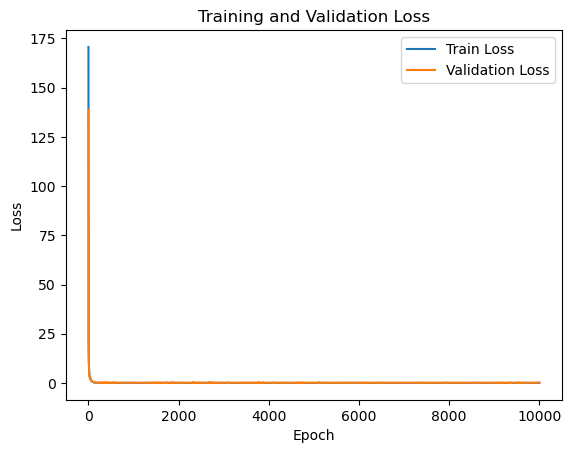

In [11]:
# === Training Loop ===
num_epochs = 10000
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        inputs = batch.to(device)
        optimizer.zero_grad()
        _, outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # === Validation ===
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch.to(device)
            _, outputs = model(inputs)
            val_loss += criterion(outputs, inputs).item()
    val_losses.append(val_loss / len(test_loader))

    # === Print Progress ===
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# === Plot Loss Curves ===
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [39]:
# === Generate Synthetic Data ===
model.eval()
n_samples = 500
latent_dim = encoding_dim

latent_samples = torch.randn(n_samples, latent_dim).to(device)
with torch.no_grad():
    synthetic_decoded = model.decoder(latent_samples)

synthetic_decoded_np = synthetic_decoded.cpu().numpy()
synthetic_original_space = pca.inverse_transform(synthetic_decoded_np)
synthetic_data = scaler.inverse_transform(synthetic_original_space)

print("Synthetic data shape:", synthetic_data.shape)

Synthetic data shape: (500, 3736)


In [40]:
# Reload real data to get column names
real_data = pd.read_csv('D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv')

# Create a DataFrame for the synthetic data with correct columns
synthetic_df = pd.DataFrame(synthetic_data, columns=real_data.columns)

# Save to CSV
synthetic_df.to_csv('C:\\Users\\Ahmed\\Final\\synthetic_data_AE.csv', index=False)

print("✅ 500 synthetic samples generated and saved successfully!")

✅ 500 synthetic samples generated and saved successfully!


In [41]:
print("X_train shape:", X_train.shape)
print("synthetic_data shape:", synthetic_data.shape)
print("Total elements in X_train:", X_train.size)
print("Total elements in synthetic_data:", synthetic_data.size)

X_train shape: (400, 3736)
synthetic_data shape: (500, 3736)
Total elements in X_train: 1494400
Total elements in synthetic_data: 1868000


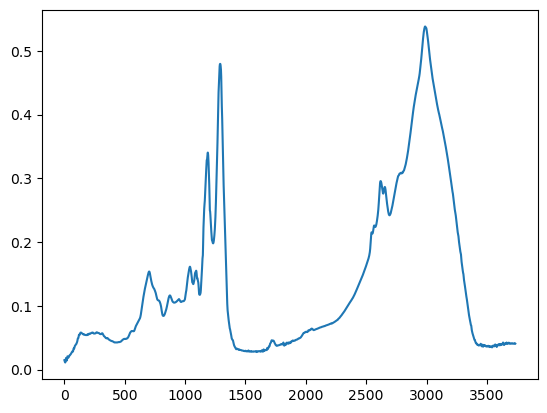

In [42]:
plt.plot(synthetic_data[20,:])

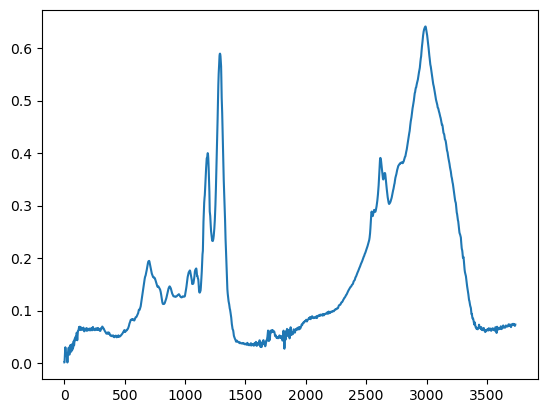

In [43]:
plt.plot(X[20,:])